In [ ]:
from infrastructure.classes import Experiment, TrainParameters
from infrastructure.training import train
import torch

experiment = Experiment(
    tensor_parameters=dict(dtype=torch.float64, device=torch.device("cpu")),
    dataset_name="fnlvqr_banana",
    dataset_number_of_points=1000,
    dataloader_parameters=dict(batch_size=256, shuffle=True),
    pushforward_operator_name="amortized_neural_quantile_regression",
    pushforward_operator_parameters=dict(
        feature_dimension=1,
        response_dimension=2,
        hidden_dimension=8,
        number_of_hidden_layers=4,
        activation_function_name="Softplus",
        network_type="PISCNN",
        potential_to_estimate_with_neural_network="u"
    ),
    train_parameters=TrainParameters(
        number_of_epochs_to_train=1000,
        verbose=True,
        optimizer_parameters=dict(lr=0.01),
        scheduler_parameters=dict(eta_min=0)
    )
)

model = train(experiment)
_ = model.eval()

Epoch: 1000, Potential Objective: 1.263, Amortization Objective: 0.269, LR: 0.000000: 100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


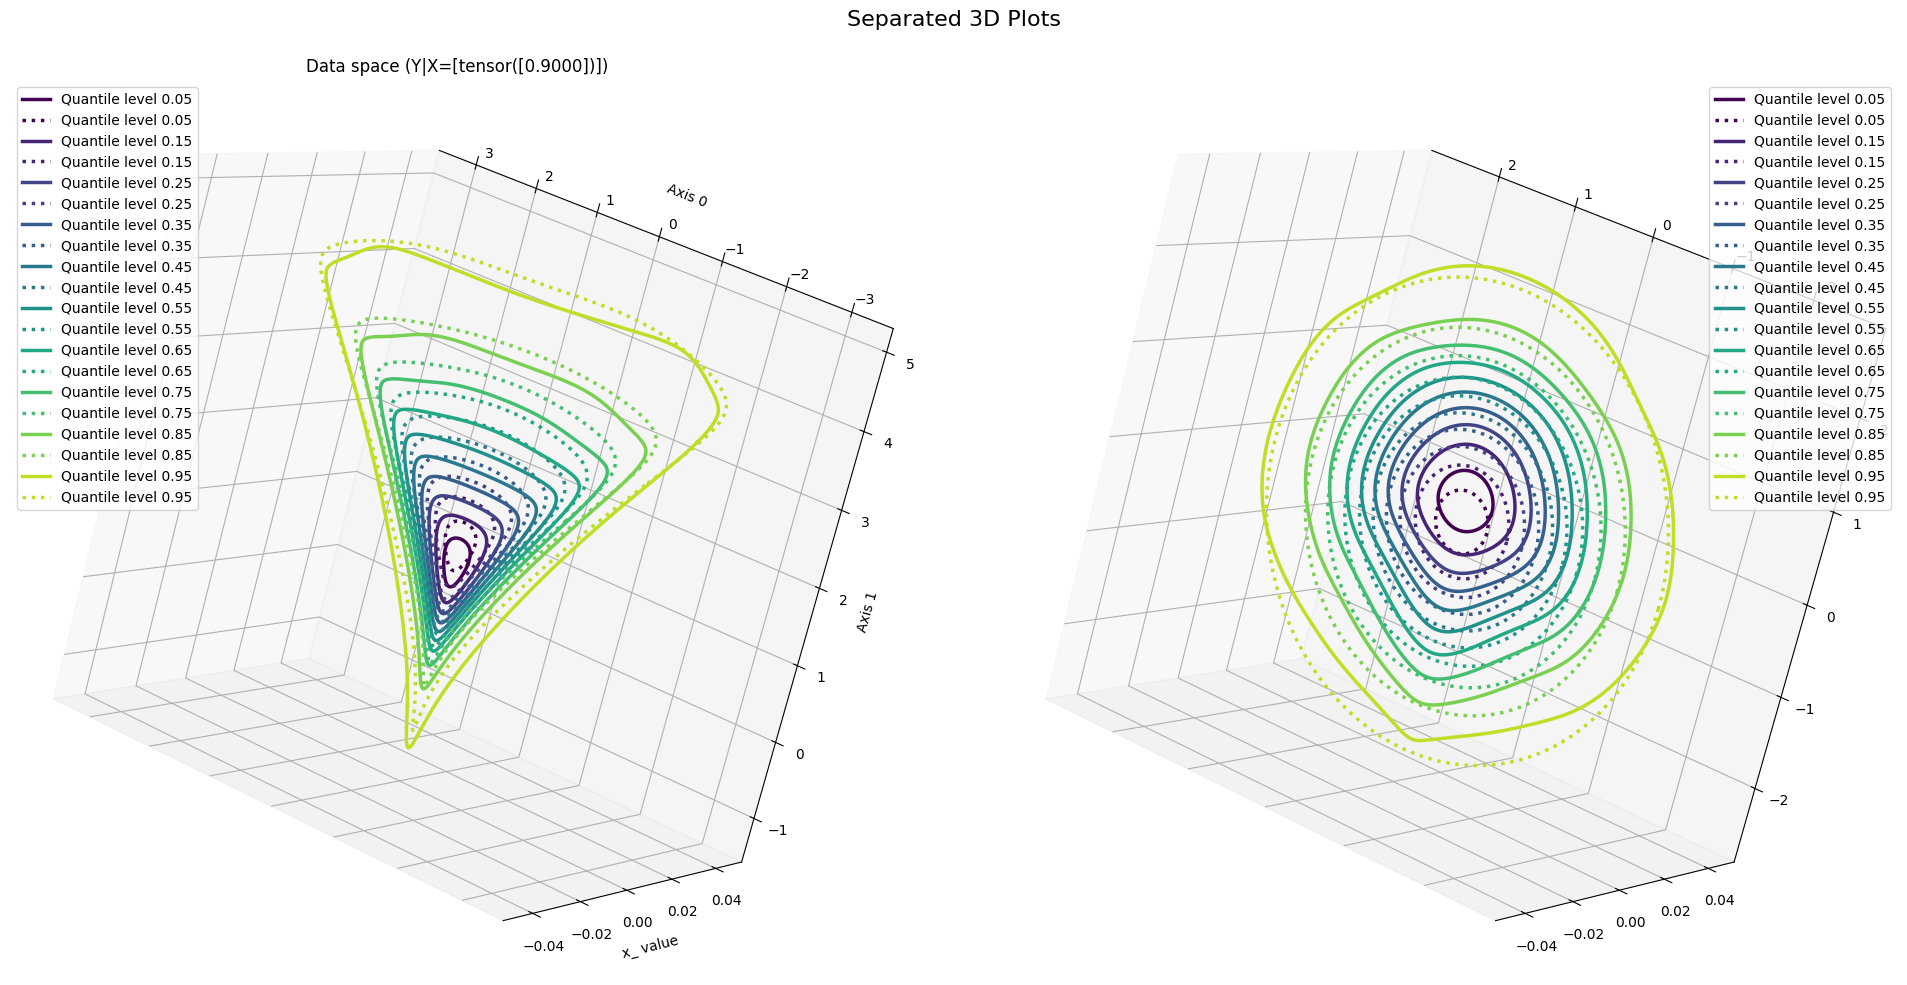

In [2]:
%matplotlib inline
from utils.plot import plot_quantile_levels_from_dataset
dataset = ConvexBananaDataset(**experiment.dataset_parameters, tensor_parameters=experiment.tensor_parameters)

plot_quantile_levels_from_dataset(
    model=model,
    dataset=dataset,
    conditional_value=torch.Tensor([[.9]]),
    number_of_quantile_levels=10,
    tensor_parameters=experiment.tensor_parameters
)